# Task 1: User-based Collaborative Filtering


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor,NearestNeighbors
from tabulate import tabulate
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import average_precision_score,mean_squared_error,ndcg_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

In [2]:
# Load user data
users = pd.read_csv(r"users.dat", sep='::', engine='python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],encoding="latin-1")
# Load movie data
movies = pd.read_csv(r"movies.dat", sep='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'],encoding="latin-1")
# Load rating data
ratings = pd.read_csv(r"ratings.dat", sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'],encoding="latin-1")


In [3]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
# Merge user data with ratings on the 'UserID' column
user_rating_data = pd.merge(users, ratings, on='UserID')

# Merge movie data with user_rating_data on the 'MovieID' column
final_dataset = pd.merge(user_rating_data, movies, on='MovieID')

# Select only the columns you need
df = final_dataset[['UserID', 'MovieID', 'Title', 'Rating']]


In [7]:
df

,UserID,MovieID,Title,Rating
0,1,1193,One Flew Over the Cuckoo's Nest (1975),5
1,2,1193,One Flew Over the Cuckoo's Nest (1975),5
2,12,1193,One Flew Over the Cuckoo's Nest (1975),4
3,15,1193,One Flew Over the Cuckoo's Nest (1975),4
4,17,1193,One Flew Over the Cuckoo's Nest (1975),5
...,...,...,...,...
1000204,5949,2198,Modulations (1998),5
1000205,5675,2703,Broken Vessels (1998),3
1000206,5780,2845,White Boys (1999),1
1000207,5851,3607,One Little Indian (1973),5


In [8]:
user_features_df = df.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)

# Convert pivot table to a sparse matrix
user_features_df_matrix = csr_matrix(user_features_df.values)

In [9]:
user_features_df

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,3.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
k_values = [3, 5, 7, 9, 11, 15, 17, 19, 21, 23, 25, 27, 29]

In [11]:
np.random.seed(42)
random_user_index = np.random.choice(user_features_df.shape[0])
random_user_index

860

In [12]:
# Initialize variables to store the best combination
best_k = None
best_rmse = float('inf')

k_values_for_plot = []
rmse_values_for_plot = []


In [13]:
for k in k_values:
    # Create the KNN model with the chosen k value and Euclidean metric
    model_knn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='brute')
    model_knn.fit(user_features_df_matrix)

    # Get the neighbors for the selected user
    distances, indices = model_knn.kneighbors(user_features_df_matrix[random_user_index, :].reshape(1, -1), n_neighbors=k + 1)

    # Predict the user ratings for the target user by taking the average of the nearest neighbors
    neighbor_ratings = user_features_df.values[indices[0][1:]]
    predicted_ratings = np.mean(neighbor_ratings, axis=0)

    # Calculate RMSE for this user's predictions
    true_ratings = user_features_df.values[random_user_index]
    mask = true_ratings != 0  # Only consider movies that the user has actually rated
    rmse = sqrt(mean_squared_error(true_ratings[mask], predicted_ratings[mask]))

    # Check if this combination is better than the current best
    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k

    # Append the results to the lists for plotting
    k_values_for_plot.append(k)
    rmse_values_for_plot.append(rmse)

In [14]:
table_data = []

# Append the k values and corresponding RMSE scores to the table data
for k, rmse in zip(k_values_for_plot, rmse_values_for_plot):
    table_data.append([k, rmse])
# Define the headers for the table
headers = ["k Value", "RMSE Score"]
# Use the tabulate function to format and print the table
table = tabulate(table_data, headers, tablefmt="grid")
print("Best K Value is",best_k)
print(table)


Best K Value is 7
+-----------+--------------+
|   k Value |   RMSE Score |
+===========+==============+
|         3 |      2.92285 |
+-----------+--------------+
|         5 |      2.85044 |
+-----------+--------------+
|         7 |      2.77493 |
+-----------+--------------+
|         9 |      2.79448 |
+-----------+--------------+
|        11 |      2.91665 |
+-----------+--------------+
|        15 |      3.07863 |
+-----------+--------------+
|        17 |      3.14312 |
+-----------+--------------+
|        19 |      3.19832 |
+-----------+--------------+
|        21 |      3.25018 |
+-----------+--------------+
|        23 |      3.29522 |
+-----------+--------------+
|        25 |      3.32659 |
+-----------+--------------+
|        27 |      3.36457 |
+-----------+--------------+
|        29 |      3.38431 |
+-----------+--------------+


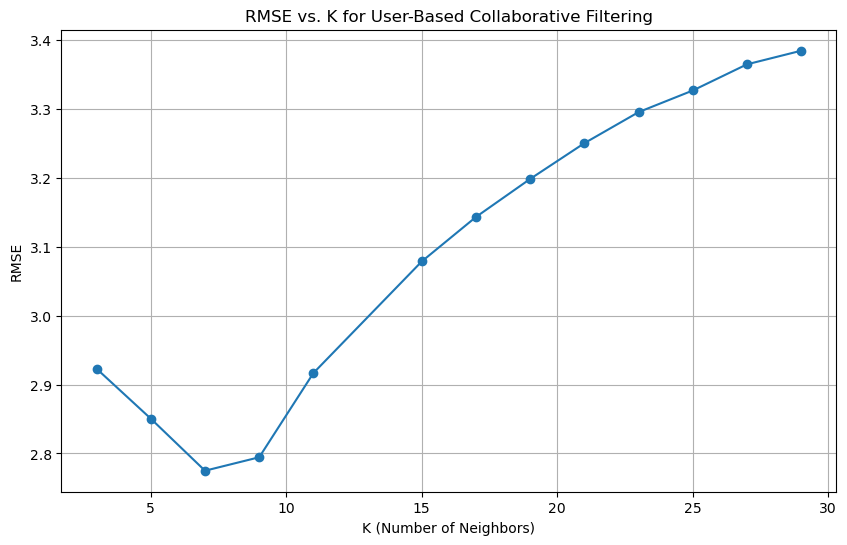

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(k_values_for_plot, rmse_values_for_plot, marker='o', linestyle='-')
plt.title('RMSE vs. K for User-Based Collaborative Filtering')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('RMSE')
plt.grid(True)


In [16]:
# Create the KNN model with the best k value and Euclidean metric for user-based collaborative filtering
best_model_knn_user = NearestNeighbors(n_neighbors=best_k, metric='euclidean', algorithm='brute')
best_model_knn_user_fit = best_model_knn_user.fit(user_features_df_matrix)

# Get the neighbors for the selected user
distances, indices = best_model_knn_user.kneighbors(user_features_df_matrix[random_user_index, :].reshape(1, -1), n_neighbors=best_k + 1)

# Predict the user ratings for the target user by taking the average of the nearest neighbors
neighbor_ratings = user_features_df.values[indices[0][1:]]
predicted_ratings = np.rint(np.mean(neighbor_ratings, axis=0))

# Prepare the data for tabulate
table_data = []

user_id = user_features_df.index[random_user_index]

for i, rating in enumerate(predicted_ratings):
    if rating > 0:
        table_data.append([user_id, user_features_df.columns[i], int(rating)])

# Add headers to the data
table_data.insert(0, ['User ID', 'Movie', 'Predicted Rating'])

# Print the table using tabulate
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))


+---------+--------------------------------------------------------------------+------------------+
| User ID |                               Movie                                | Predicted Rating |
+---------+--------------------------------------------------------------------+------------------+
|   861   |                     About Last Night... (1986)                     |        1         |
|   861   | Adventures of Buckaroo Bonzai Across the 8th Dimension, The (1984) |        1         |
|   861   |                          Airplane! (1980)                          |        3         |
|   861   |                     As Good As It Gets (1997)                      |        1         |
|   861   |                       Bachelor Party (1984)                        |        2         |
|   861   |                       Back to School (1986)                        |        2         |
|   861   |                     Back to the Future (1985)                      |        4         |


# Task 2: Item-based Filtering

In [17]:
movie_features_df = df.pivot_table(index='Title', columns='UserID', values='Rating').fillna(0)

# Convert pivot table to a sparse matrix
movie_features_df_matrix = csr_matrix(movie_features_df.values)

In [18]:
k_values = [3, 5, 7, 9, 11, 15, 17, 19, 21, 23, 25, 27, 29]
similarity_metrics = ['cosine', 'euclidean']

In [19]:
np.random.seed(42)
random_movie_index = np.random.choice(movie_features_df.shape[0])
random_movie_index

3174

In [20]:
movie_features_df

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Effect (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Kelvin (Kjærlighetens kjøtere) (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Initialize variables to store the best combination
best_k = None
best_metric = None
best_rmse = float('inf')

# Initialize a list to store results for the table
results_table = []

In [22]:
# Loop through different k values and similarity metrics
for k in k_values:
    for metric in similarity_metrics:
        # Create the KNN model with the chosen k value and similarity metric
        model_knn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='brute')
        model_knn.fit(movie_features_df_matrix)

        # Get the neighbors for the selected movie
        distances, indices = model_knn.kneighbors(movie_features_df_matrix[random_movie_index, :].reshape(1, -1), n_neighbors=k + 1)

        # Predict the user ratings for the movie by taking the average of the nearest neighbors
        neighbor_ratings = movie_features_df.values[indices[0][1:]]
        predicted_ratings = np.mean(neighbor_ratings, axis=0)

        # Calculate RMSE for this movie's predictions
        true_ratings = movie_features_df.values[random_movie_index]
        mask = true_ratings != 0  # Only consider users who actually rated the movie
        rmse = sqrt(mean_squared_error(true_ratings[mask], predicted_ratings[mask]))

        # Check if this combination is better than the current best
        if rmse < best_rmse:
            best_rmse = rmse
            best_k = k
            best_metric = metric

        # Append the results to the table
        results_table.append([k, metric, rmse])

In [23]:
print(f"Best Combination - K: {best_k}, Similarity Metric: {best_metric}, RMSE: {best_rmse}")
# Create a table using the tabulate library
table = tabulate(results_table, headers=['K', 'Similarity Metric', 'RMSE'], tablefmt='pretty')
print(table)

Best Combination - K: 25, Similarity Metric: cosine, RMSE: 2.8376371535812357
+----+-------------------+--------------------+
| K  | Similarity Metric |        RMSE        |
+----+-------------------+--------------------+
| 3  |      cosine       | 3.0870559648173743 |
| 3  |     euclidean     | 3.1717233580230575 |
| 5  |      cosine       | 3.0422663616758836 |
| 5  |     euclidean     | 3.0422663616758836 |
| 7  |      cosine       | 3.034599019440824  |
| 7  |     euclidean     | 3.054193915087517  |
| 9  |      cosine       |  2.85399704717772  |
| 9  |     euclidean     | 3.1272475298591966 |
| 11 |      cosine       | 2.8881457523539966 |
| 11 |     euclidean     | 3.176318924035136  |
| 15 |      cosine       | 2.8589640105596317 |
| 15 |     euclidean     | 3.2637349481791276 |
| 17 |      cosine       | 2.888948037131453  |
| 17 |     euclidean     | 3.2581259360842107 |
| 19 |      cosine       | 2.871530090885272  |
| 19 |     euclidean     | 3.2744352601895814 |
| 21 |    

In [24]:
# Extract data for plotting
k_labels = [f'K={k}' for k in k_values]
rmse_cosine = [result[2] for result in results_table if result[1] == 'cosine']
rmse_euclidean = [result[2] for result in results_table if result[1] == 'euclidean']

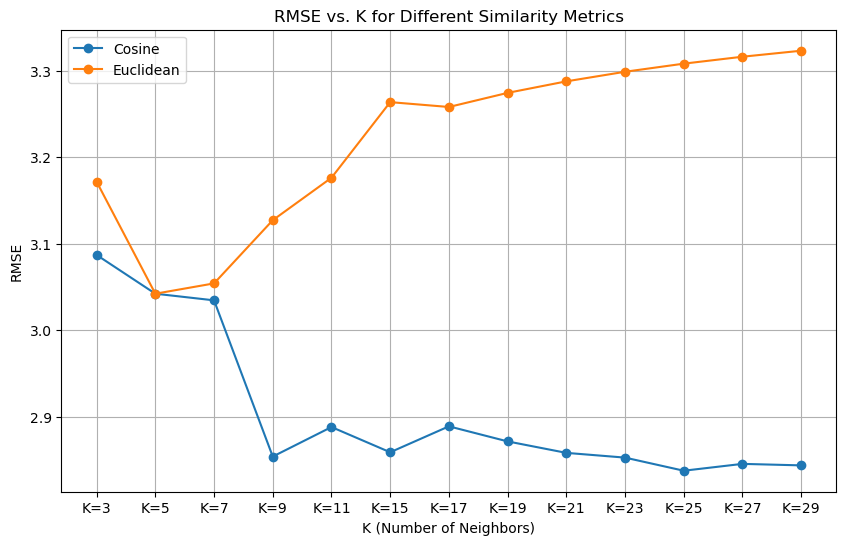

In [25]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_labels, rmse_cosine, marker='o', label='Cosine')
plt.plot(k_labels, rmse_euclidean, marker='o', label='Euclidean')
plt.title('RMSE vs. K for Different Similarity Metrics')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('RMSE')
plt.legend()
plt.grid()

In [26]:
# Create the KNN model with the best k value and similarity metric
best_model_knn_item = NearestNeighbors(n_neighbors=best_k, metric=best_metric, algorithm='brute')
best_model_knn_item_fit=best_model_knn_item.fit(movie_features_df_matrix)

# Get the neighbors for the selected movie
distances, indices = best_model_knn_item.kneighbors(movie_features_df_matrix[random_movie_index, :].reshape(1, -1), n_neighbors=best_k + 1)

# Predict the user ratings for the movie by taking the average of the nearest neighbors
neighbor_ratings = movie_features_df.values[indices[0][1:]]
predicted_ratings = np.rint(np.mean(neighbor_ratings, axis=0))

# Prepare the data for tabulate
table_data = []

movie_title = movie_features_df.index[random_movie_index]

for i, rating in enumerate(predicted_ratings):
    if rating > 0:
        table_data.append([f"User {i}", int(rating)])

# Add headers to the data
table_data.insert(0, ['User', 'Predicted Rating'])

# Print the table using tabulate
print(f"Predicted Ratings for Movie {movie_title}:")
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))


Predicted Ratings for Movie Stiff Upper Lips (1998):
+-----------+------------------+
|   User    | Predicted Rating |
+-----------+------------------+
| User 194  |        2         |
| User 1353 |        1         |
| User 1469 |        1         |
| User 4168 |        1         |
| User 4276 |        1         |
| User 4681 |        2         |
| User 5332 |        1         |
+-----------+------------------+


# Task 3: A Better Recommender System

## Option1RecSys

Recommendation System Using Autoencoders
by Diana Ferreira, Sofia Silva, António Abelha, and José Machado

In [27]:
df = final_dataset[['UserID', 'Gender', 'Age', 'Occupation', 'MovieID', 'Title', 'Genres', 'Rating']]
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
# Split the genres into a list of individual genres
df['Genres'] = df['Genres'].str.split('|')

# Get a list of unique genres
unique_genres = set(genre for genres in df['Genres'] for genre in genres)

# Create binary columns for each unique genre and set them to 1 or 0
for genre in unique_genres:
    df[genre] = df['Genres'].apply(lambda x: 1 if genre in x else 0)

# Drop the original 'Genres' column
df = df.drop(columns=['Genres'])

In [28]:
df

,UserID,Gender,Age,Occupation,MovieID,Title,Rating,Fantasy,Musical,Thriller,...,Mystery,Western,Film-Noir,Sci-Fi,Action,Drama,Adventure,Animation,Children's,Documentary
0,1,0,1,10,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,56,16,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,12,1,25,12,1193,One Flew Over the Cuckoo's Nest (1975),4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,15,1,25,7,1193,One Flew Over the Cuckoo's Nest (1975),4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,17,1,50,1,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,5949,1,18,17,2198,Modulations (1998),5,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000205,5675,1,35,14,2703,Broken Vessels (1998),3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1000206,5780,1,18,17,2845,White Boys (1999),1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1000207,5851,0,18,20,3607,One Little Indian (1973),5,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [29]:
from sklearn.model_selection import train_test_split 

X = df.drop(["MovieID", "Rating", "Title", "UserID"], axis=1)
y = df['Rating']

# Splitthe data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Define the dimensions of the latent space
latent_dim = 64
# Define the autoencoder model with the correct input shape
input_layer = keras.layers.Input(shape=(X_train.shape[1],))  # Use the number of features in your training data
encoder = keras.layers.Dense(latent_dim, activation='relu')(input_layer)
decoder = keras.layers.Dense(X_train.shape[1], activation='linear')(encoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the model with MSE as the loss function
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder_fit = autoencoder.fit(X_train, X_train, epochs=1, batch_size=64, shuffle=True, validation_data=(X_test, X_test))


12503/12503 [==============================] - 14s 1ms/step - loss: 0.2366 - val_loss: 9.0143e-05


In [31]:
# Calculate RMSE for the test data
y_pred = autoencoder.predict(X_test)
rmse = sqrt(mean_squared_error(X_test, y_pred))
print("Root Mean Squared Error:", rmse)

6252/6252 [==============================] - 5s 718us/step
Root Mean Squared Error: 0.009494355143964529


In [32]:
df.head()

,UserID,Gender,Age,Occupation,MovieID,Title,Rating,Fantasy,Musical,Thriller,...,Mystery,Western,Film-Noir,Sci-Fi,Action,Drama,Adventure,Animation,Children's,Documentary
0,1,0,1,10,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,56,16,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,12,1,25,12,1193,One Flew Over the Cuckoo's Nest (1975),4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,15,1,25,7,1193,One Flew Over the Cuckoo's Nest (1975),4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,17,1,50,1,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [33]:
df.shape

(1000209, 25)

# MovieAvg 

In [34]:
# Filter users who have rated more than 100 movies
user_ratings = df.groupby('UserID')['MovieID'].count()
active_users = user_ratings[user_ratings > 100].index

# Initialize lists and dictionaries to store results
recommended_movies = {}
ap_scores = {}
ndcg_scores = {}

In [35]:
# Calculate the Movie Average Ratings
movie_avg_ratings = df.groupby('MovieID')['Rating'].mean().reset_index()


In [36]:
# Randomly select 5 users
#random.seed(42)  # For reproducibility
np.random.seed(42)
random_users = np.random.choice(active_users, 5, replace=False)
random_users

array([1837, 2659, 1854,  778, 1272], dtype=int64)

In [37]:
from sklearn.metrics import average_precision_score, mean_squared_error, ndcg_score
# Loop through the selected random users
for user_id in random_users:
    # Get the user's ground truth ratings
    user_ground_truth = df[(df['UserID'] == user_id)] 

    # Get the recommended movies based on Movie Average
    top_movies = movie_avg_ratings.sort_values(by='Rating', ascending=False).head(30)

    # Extract the MovieIDs of the recommended movies
    recommended_movie_ids = top_movies['MovieID'].tolist()

    # Create a relevance vector for the recommended movies
    relevance = [1 if movie_id in user_ground_truth['MovieID'].values else 0 for movie_id in recommended_movie_ids]

    # Calculate AP and NDCG
    ap = average_precision_score(relevance, np.arange(1, 31))  # Use ranking positions as scores
    ndcg = ndcg_score([relevance], [relevance])

    # Store the recommended movies, AP, and NDCG
    recommended_movies[user_id] = recommended_movie_ids
    ap_scores[user_id] = ap
    ndcg_scores[user_id] = ndcg

In [38]:
# Display the results neatly
for user_id in random_users:
    if not (np.isnan(ap_scores[user_id]) or np.isnan(ndcg_scores[user_id])):
        print(f"User ID: {user_id}")
        print("Recommended Movies:")
        for idx, movie_id in enumerate(recommended_movies[user_id], start=1):
            movie_title = df[df['MovieID'] == movie_id]['Title'].values[0]
            print(f"{idx}. {movie_title}")
        print(f"Average Precision (AP): {ap_scores[user_id]:.3f}")
        print(f"NDCG (Normalized Discounted Cumulative Gain): {ndcg_scores[user_id]:.3f}")
        print()

User ID: 1837
Recommended Movies:
1. Schlafes Bruder (Brother of Sleep) (1995)
2. Bittersweet Motel (2000)
3. Follow the Bitch (1998)
4. Song of Freedom (1936)
5. Gate of Heavenly Peace, The (1995)
6. Baby, The (1973)
7. One Little Indian (1973)
8. Smashing Time (1967)
9. Ulysses (Ulisse) (1954)
10. Lured (1947)
11. I Am Cuba (Soy Cuba/Ya Kuba) (1964)
12. Lamerica (1994)
13. Apple, The (Sib) (1998)
14. Sanjuro (1962)
15. Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)
16. Shawshank Redemption, The (1994)
17. Godfather, The (1972)
18. Close Shave, A (1995)
19. Usual Suspects, The (1995)
20. Schindler's List (1993)
21. Wrong Trousers, The (1993)
22. Inheritors, The (Die Siebtelbauern) (1998)
23. Callejón de los milagros, El (1995)
24. Dry Cleaning (Nettoyage à sec) (1997)
25. Dangerous Game (1993)
26. Mamma Roma (1962)
27. Bells, The (1926)
28. Skipped Parts (2000)
29. Hour of the Pig, The (1993)
30. Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
Average Precision (AP)

In [39]:
# Create a list to store the results for tabulation
table_data = []

# Loop through the selected random users
for user_id in random_users:
    if not (np.isnan(ap_scores[user_id]) or np.isnan(ndcg_scores[user_id])):
        user_data = [user_id, ap_scores[user_id], ndcg_scores[user_id]]
        table_data.append(user_data)

# Display the results in a table
table_headers = ["User ID", "AP", "NDCG"]
table = tabulate(table_data, headers=table_headers, tablefmt="pipe")
print(table)


|   User ID |       AP |   NDCG |
|----------:|---------:|-------:|
|      1837 | 0.184632 |      1 |
|      2659 | 0.184632 |      1 |
|      1854 | 0.184632 |      1 |
|       778 | 0.184632 |      1 |
|      1272 | 0.257974 |      1 |


In [40]:
# Filter users who have rated more than 100 movies
selected_users = user_features_df[user_features_df.sum(axis=1) > 100].index
np.random.seed(42)
# Randomly select 5 users from the filtered users
selected_users = np.random.choice(selected_users, 5)
selected_users

array([ 959, 5963, 5780, 5744, 4181], dtype=int64)

In [41]:
recommended_movies = {}

for user_index in random_users:
    distances, indices = best_model_knn_user.kneighbors(user_features_df_matrix[user_index, :].reshape(1, -1), n_neighbors=best_k + 1)
    neighbor_ratings = user_features_df.values[indices[0][1:]]
    predicted_ratings = np.mean(neighbor_ratings, axis=0)

    # Sort movies by predicted ratings in descending order
    recommended_movie_indices = np.argsort(predicted_ratings)[::-1]

    # Get the top 30 recommended movies for each user
    recommended_movies[user_index] = user_features_df.columns[recommended_movie_indices][:30]


In [42]:
evaluation_results = []

for user_index, top_movies in recommended_movies.items():
    true_ratings = user_features_df.values[user_index]

    # Create a binary indicator for whether the user has rated each movie in the top 30 recommendations
    binary_true_ratings = [1 if movie in top_movies else 0 for movie in user_features_df.columns]

    # Calculate Average Precision (AP)
    ap = average_precision_score(binary_true_ratings, predicted_ratings)

    # Calculate Normalized Discounted Cumulative Gain (NDCG)
    true_ratings = true_ratings[recommended_movie_indices]  # Order true ratings in the same order as recommendations
    ndcg = ndcg_score([true_ratings], [predicted_ratings])

    evaluation_results.append({'User ID': user_index, 'AP': ap, 'NDCG': ndcg})

In [43]:
# Print the evaluation results
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)


   User ID        AP      NDCG
0     1837  0.011046  0.292472
1     2659  0.108610  0.351040
2     1854  0.054530  0.400383
3      778  0.025187  0.345757
4     1272  0.993939  0.620401


In [44]:
recommended_movies

{1837: Index(['Perfect Storm, The (2000)', 'Gladiator (2000)', 'Frequency (2000)',
        'Mission: Impossible 2 (2000)', 'Patriot, The (2000)', 'U-571 (2000)',
        'Shanghai Noon (2000)', 'X-Men (2000)', 'What Lies Beneath (2000)',
        'Erin Brockovich (2000)', 'Shaft (2000)', 'Romeo Must Die (2000)',
        'Road Trip (2000)', 'Pitch Black (2000)', 'Dinosaur (2000)',
        '28 Days (2000)', 'Final Destination (2000)', 'Skulls, The (2000)',
        'Rules of Engagement (2000)', 'Scary Movie (2000)',
        'Gone in 60 Seconds (2000)', 'Return to Me (2000)',
        'Breakfast Club, The (1985)', 'Boiler Room (2000)',
        'Small Time Crooks (2000)', 'Silence of the Lambs, The (1991)',
        'High Fidelity (2000)', 'Mission to Mars (2000)',
        'Me, Myself and Irene (2000)', 'American Psycho (2000)'],
       dtype='object', name='Title'),
 2659: Index(['Star Wars: Episode VI - Return of the Jedi (1983)',
        'Forrest Gump (1994)', 'When Harry Met Sally... (1989

In [45]:
# Display the recommended movie titles for each selected user
for user_id in random_users:
    user_id = int(user_id)  # Ensure user_id is an integer
    recommended_movie_titles = recommended_movies[user_id]
    
    print(f"User {user_id} Recommended Movies:")
    for i, movie_title in enumerate(recommended_movie_titles):
        print(f"{i + 1}. {movie_title}")


User 1837 Recommended Movies:
1. Perfect Storm, The (2000)
2. Gladiator (2000)
3. Frequency (2000)
4. Mission: Impossible 2 (2000)
5. Patriot, The (2000)
6. U-571 (2000)
7. Shanghai Noon (2000)
8. X-Men (2000)
9. What Lies Beneath (2000)
10. Erin Brockovich (2000)
11. Shaft (2000)
12. Romeo Must Die (2000)
13. Road Trip (2000)
14. Pitch Black (2000)
15. Dinosaur (2000)
16. 28 Days (2000)
17. Final Destination (2000)
18. Skulls, The (2000)
19. Rules of Engagement (2000)
20. Scary Movie (2000)
21. Gone in 60 Seconds (2000)
22. Return to Me (2000)
23. Breakfast Club, The (1985)
24. Boiler Room (2000)
25. Small Time Crooks (2000)
26. Silence of the Lambs, The (1991)
27. High Fidelity (2000)
28. Mission to Mars (2000)
29. Me, Myself and Irene (2000)
30. American Psycho (2000)
User 2659 Recommended Movies:
1. Star Wars: Episode VI - Return of the Jedi (1983)
2. Forrest Gump (1994)
3. When Harry Met Sally... (1989)
4. Princess Bride, The (1987)
5. Say Anything... (1989)
6. Gone with the Wind 

## Option1RecSys 

In [46]:
# Initialize lists to store AP and NDCG values for each user
ap_values = []
ndcg_values = []

# Select 5 users who have rated more than 100 movies each
user_ratings = df['UserID'].value_counts()
user_ratings[user_ratings>=100]


UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
2699     100
3334     100
38       100
5708     100
1567     100
Name: count, Length: 2945, dtype: int64

In [47]:
selected_users = user_ratings[user_ratings > 100].sample(5, random_state=42).index
selected_users

Index([4418, 840, 175, 1202, 5000], dtype='int64', name='UserID')

In [48]:

# Determine the number of features in your data (adjust based on your actual feature set)
num_features = len(df.columns) - 4  # Assuming you have UserID, MovieID, Title, and Rating columns

# Define the custom RMSE loss function
def custom_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Define the autoencoder model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_features, activation='sigmoid')
])

# Use custom RMSE as the loss function
model.compile(optimizer='adam', loss=custom_rmse)

# Train the autoencoder model on your movie rating data
train_data = df.drop(['UserID', 'MovieID', 'Title', 'Rating'], axis=1).values  # Adjust the data columns
train_data = train_data.astype('float32')  # Convert to float32
train_data /= train_data.max()  # Normalize to [0, 1]

model.fit(train_data, train_data, epochs=10, batch_size=32)  # Adjust the number of epochs and batch size

# Generate movie recommendations for selected users
for user_id in selected_users:
    # Create user-item matrix for the selected user
    user_ratings = df[df['UserID'] == user_id]
    user_features = user_ratings.drop(["MovieID", "Rating", "Title", "UserID"], axis=1)

    # Use the autoencoder model to predict user's ratings
    predicted_ratings = model.predict(user_features)

    # Sort movies by predicted ratings and recommend the top-30
    top_30_indices = np.argsort(predicted_ratings[0])[::-1][:30]

    # Get the corresponding MovieIDs for the top-30 recommended movies
    top_30_movie_ids = user_ratings['MovieID'].iloc[top_30_indices].tolist()

    # Get the titles of the top-30 recommended movies (unique and not repeated)
    top_30_movie_titles = df[df['MovieID'].isin(top_30_movie_ids)]['Title'].unique()

    # Ensure there are at least 30 recommendations
    while len(top_30_movie_titles) < 30:
        additional_movies = df[~df['MovieID'].isin(top_30_movie_ids)]['Title'].sample(30 - len(top_30_movie_titles)).values
        top_30_movie_titles = np.concatenate((top_30_movie_titles, additional_movies))

    top_30_movie_titles = top_30_movie_titles[:30]  # Limit to 30 recommendations

    # Calculate ground truth (user's actual ratings)
    user_actual_ratings = user_ratings['Rating']

    # Create a binary indicator for the top-30 recommended movies
    recommended_movies_indicator = np.isin(top_30_movie_ids, user_ratings['MovieID'])

    # Calculate performance metrics (AP and NDCG)
    ap = average_precision_score(recommended_movies_indicator, np.arange(1, len(recommended_movies_indicator) + 1))
    ndcg = ndcg_score([recommended_movies_indicator], [np.arange(1, len(recommended_movies_indicator) + 1)])

    # Store user recommendations and performance metrics
    user_recommendations = {
        'UserID': user_id,
        'Recommendations': top_30_movie_titles,
        'AP': ap,
        'NDCG': ndcg
    }

    # Print user recommendations and performance metrics
    print(f"User {user_id}")
    print("Recommendations:")
    for j, title in enumerate(user_recommendations['Recommendations']):
        print(f"{j + 1}: {title}")
    print(f"AP score: {user_recommendations['AP']}")
    print(f"NDCG score: {user_recommendations['NDCG']}\n")

    ap_values.append(ap)
    ndcg_values.append(ndcg)

# Calculate average AP and NDCG
average_ap = np.mean(ap_values)
average_ndcg = np.mean(ndcg_values)

print(f"Average AP = {average_ap}")
print(f"Average NDCG = {average_ndcg}")


Epoch 1/10
31257/31257 [==============================] - 34s 1ms/step - loss: 0.0041
Epoch 2/10
31257/31257 [==============================] - 34s 1ms/step - loss: 0.0016
Epoch 3/10
31257/31257 [==============================] - 35s 1ms/step - loss: 0.0013
Epoch 4/10
31257/31257 [==============================] - 34s 1ms/step - loss: 0.0012
Epoch 5/10
31257/31257 [==============================] - 34s 1ms/step - loss: 0.0011
Epoch 6/10
31257/31257 [==============================] - 34s 1ms/step - loss: 0.0011
Epoch 7/10
31257/31257 [==============================] - 33s 1ms/step - loss: 8.8965e-04
Epoch 8/10
31257/31257 [==============================] - 34s 1ms/step - loss: 7.1881e-04
Epoch 9/10
31257/31257 [==============================] - 34s 1ms/step - loss: 6.9649e-04
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
User 4418
Recommendations:
1: One Flew Over the Cuckoo's Nest (1975)
2: Erin Brockovich (2000)
3: Wizard of Oz, The (1939)
4: Back to the Future (198

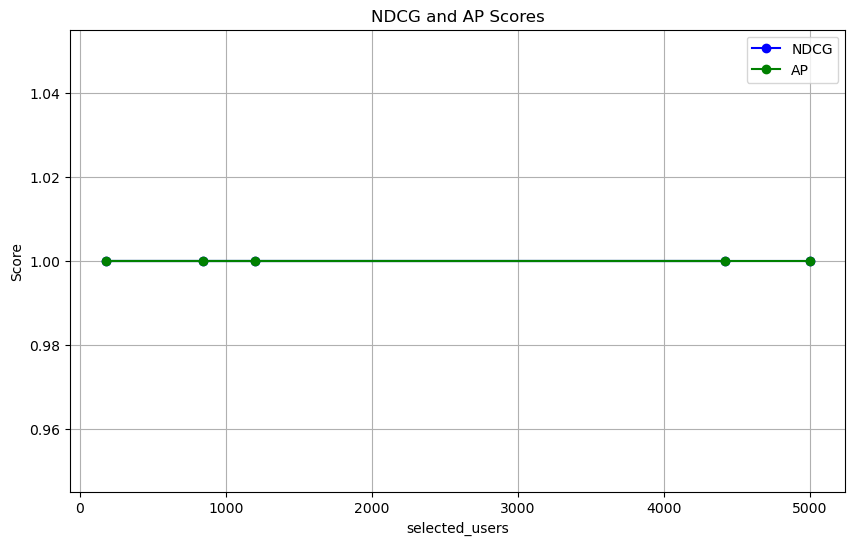

In [55]:
import matplotlib.pyplot as plt

# Create a line plot for NDCG scores
plt.figure(figsize=(10, 6))
plt.plot(selected_users, ndcg_values, marker='o', label='NDCG', color='blue')

# Create a line plot for AP scores
plt.plot(selected_users, ap_values, marker='o', label='AP', color='green')

# Add labels and a legend
plt.xlabel('selected_users')
plt.ylabel('Score')
plt.title('NDCG and AP Scores')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
